In [36]:
from astropy.io import fits
import numpy as np
from glob import glob 
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.wcs as wcs
import astropy.units as u
from astropy.convolution import convolve_fft
import numpy as np
from radio_beam import Beam
from reproject import reproject_interp
from matplotlib import pyplot as plt
from glob import glob 
from tqdm.auto import tqdm
import warnings 
from astropy.table import Table, hstack, join
import pickle
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.modeling import models, fitting

warnings.filterwarnings('ignore')

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in" 

plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

import warnings 
warnings.filterwarnings('ignore')

In [37]:
def save_pickle(a, filename):
    """
    Save an object to a pickle file.
    """
    with open(filename, 'wb') as handle:
        pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print('[INFO] [save_pickle] Saved to %s' %filename)

def load_pickle(filename):
    """
    Load an object from a pickle file.
    """
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)
    print('[INFO] [load_pickle] Load %s' %filename)
    return b

def get_hdu(rootdir, filename, hdu_id=0):
    filename_full = glob(rootdir+filename)[0]
    print(filename_full)
    if hdu_id == 'all':
        hdu = fits.open(filename_full)
    else:
        hdu = fits.open(filename_full)[hdu_id]
    return(hdu)

def get_flux_nebs(hdu1, hdu2, hdu_neb1, hdu_neb2, filter='', make_plots=True):

    data_neb = hdu_neb1.data.copy()
    ids1 = np.unique(data_neb)
    ids1.sort()
    ids1 = list(ids1)
    ids1.remove(-1)

    data_neb = hdu_neb2.data.copy()
    ids2 = np.unique(data_neb)
    ids2.sort()
    ids2 = list(ids2)
    ids2.remove(-1)

    ids = []
    for id in tqdm(np.unique(np.hstack([ids1, ids2]))):
        if (id in ids1) &  (id in ids2): 
            ids += [id]

    flux_1 = np.ones(len(ids))
    flux_2 = np.ones(len(ids))
    
    for i in tqdm(range(len(ids))): 

        id = ids[i]

        mask1 = hdu_neb1.data == id
        mask2 = hdu_neb2.data == id

        flux_1[i] = np.nansum(hdu1.data[mask1])
        flux_2[i] = np.nansum(hdu2.data[mask2])
        
    return(flux_1, flux_2, ids)

def get_museprops(galaxy, muscat_file):
    """
    Get properties from MUSE catalouge
    """

    print(f'[INFO] [get_MuseProps] Getting MUSE catalouge properties for {galaxy}...')
    muscat_table = Table.read(muscat_file)
    muscat_table = muscat_table[muscat_table['gal_name'] == galaxy.swapcase()]
    return(muscat_table)


In [57]:
galaxies = [
            'ngc628e',
            'ngc628c',  
            'ngc1087',          
            'ngc1300',
            'ngc1365n',
            'ngc1385',
            'ngc1433',
            'ngc1566',
            'ngc1672',
            'ngc3351',
            'ngc4254e',
            'ngc4321',
            'ngc5068s',
            'ngc5068n',
            'ngc7496',
            ]

galaxies_muse = [
            'ngc0628',
            'ngc0628',  
            'ngc1087',          
            'ngc1300',
            'ngc1365',
            'ngc1385',
            'ngc1433',
            'ngc1566',
            'ngc1672',
            'ngc3351',
            'ngc4254',
            'ngc4321',
            'ngc5068',
            'ngc5068',
            'ngc7496',
            ]

# galaxies = ['ngc628e']
# galaxies_muse = ['ngc0628']

root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
muscat_table_file = '%s/data_misc/nebulae_catalogue/Nebulae_catalogue_v3.fits' %root_dir

In [4]:
muscat_table_joined_all = {}
run = False 

if run: 
    for galaxy, galaxy_muse in zip(galaxies, galaxies_muse): 

        # Load files for galaxy
        print (galaxy, galaxy_muse)
        rootdir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/%s/' %galaxy
        hdu_muse_neb    = get_hdu(rootdir, 'muse/%s_nebmask.fits' %galaxy_muse.upper())
        hdu_muse        = get_hdu(rootdir, 'muse/%s*_MAPS.fits' %galaxy_muse.upper(), 'all')
        hdu_muse_ha     = hdu_muse['HA6562_FLUX']
        hdu_hst_ha_crop = get_hdu(rootdir, 'hst_contsub/%s_hst_ha_crop.fits' %galaxy)

        # Load MUSE properties
        muscat_table = get_museprops(galaxy_muse, muscat_table_file)

        # Reproject MUSE mask to HST grid
        data_output = reproject_interp(hdu_muse_neb, hdu_hst_ha_crop.header, order='nearest-neighbor')[0]
        hdu_muse_neb_re = fits.PrimaryHDU(data_output, hdu_hst_ha_crop.header)

        # Extract fluxes from MUSE and HST 
        flux_1, flux_2, ids = get_flux_nebs(hdu_muse_ha, hdu_hst_ha_crop, hdu_muse_neb, hdu_muse_neb_re)

        # Make MUSE catalouge table
        unit = muscat_table['HA6562_FLUX'].unit
        data = [ids, flux_1*unit, flux_2*unit, (flux_2*unit)/(flux_1*unit)]
        names = ['region_ID', 'flux_muse', 'flux_hst', 'flux_hst/muse']
        table_neb = Table(data=data, names=names)
        muscat_table_joined = join(table_neb, muscat_table, keys='region_ID')

        muscat_table_joined_all[galaxy] = muscat_table_joined

    save_pickle(muscat_table_joined_all, './muscat_table_joined_all.pkl')
else:
    muscat_table_joined_all = load_pickle('./muscat_table_joined_all.pkl')

[INFO] [load_pickle] Load ./muscat_table_joined_all.pkl


In [5]:
muscat_table_joined_all

{'ngc628e': <Table length=434>
 region_ID      flux_muse            flux_hst      ... HII_class_v2 HII_class_v3
           1e-20 erg / (s cm2) 1e-20 erg / (s cm2) ...                          
  float64        float64             float64       ...    int64        int64    
 --------- ------------------- ------------------- ... ------------ ------------
       4.0   80592.81774301818   424.4479675292969 ...            1            1
       5.0  120878.95924304113                 0.0 ...            1            1
      10.0    70056.4163881328       87338.2265625 ...            1            1
      11.0   119128.2951640966                 0.0 ...            1            1
      19.0  14653.954972316958    11081.0576171875 ...            1            1
      37.0   84820.63507771723           95781.375 ...            1            1
      46.0   14013.66384694474        39205.609375 ...            0            0
      49.0   51941.58562503678                 0.0 ...            1           

In [6]:
bbox = dict(facecolor='whitesmoke',  alpha=0.95, boxstyle='round')

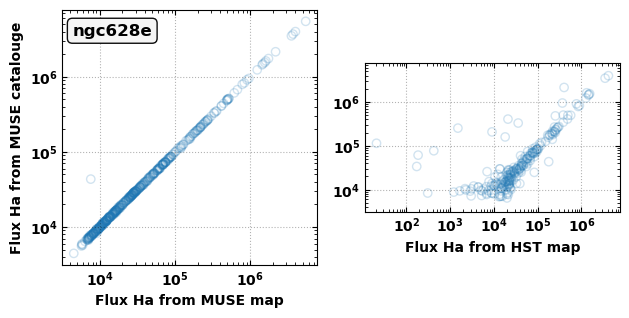

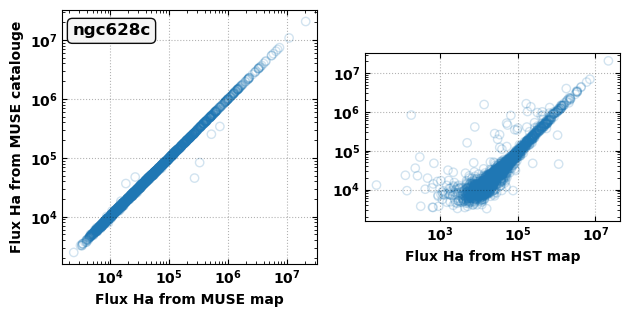

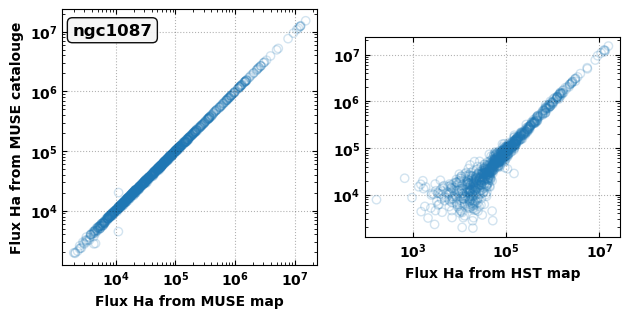

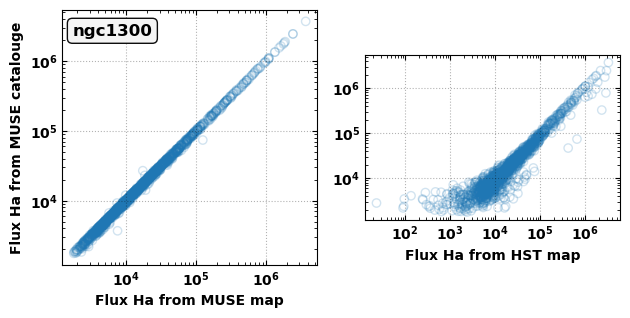

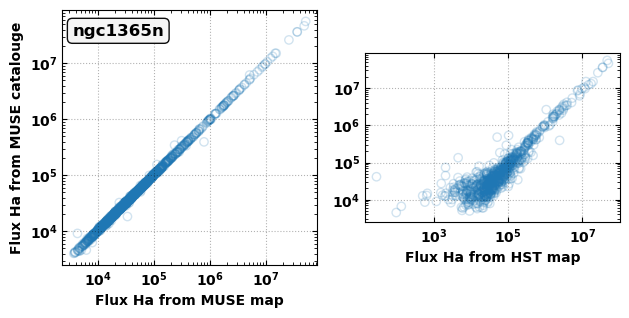

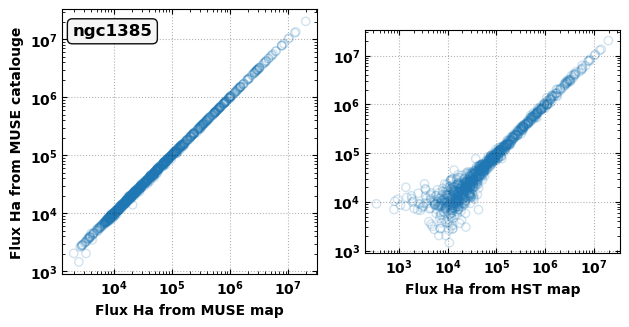

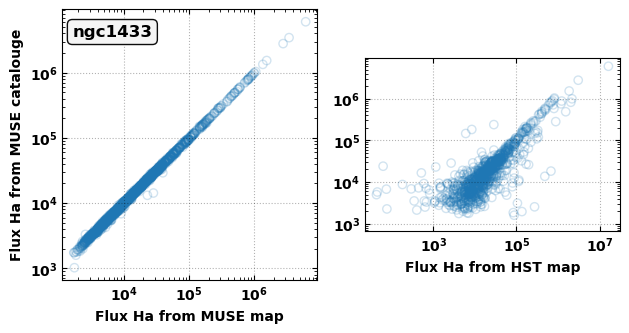

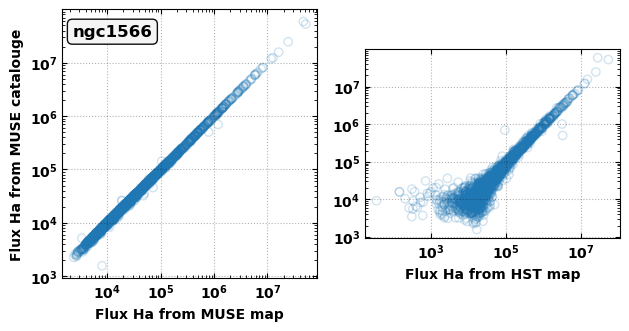

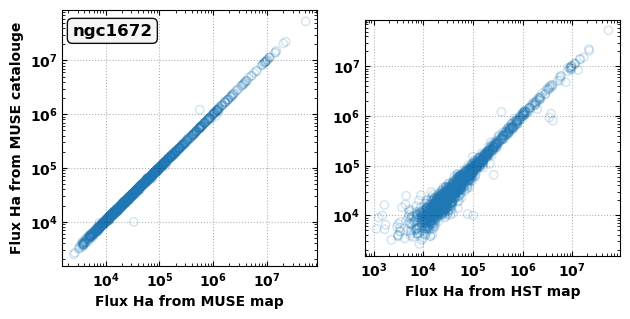

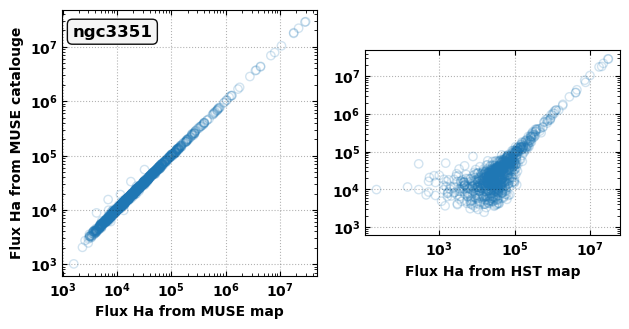

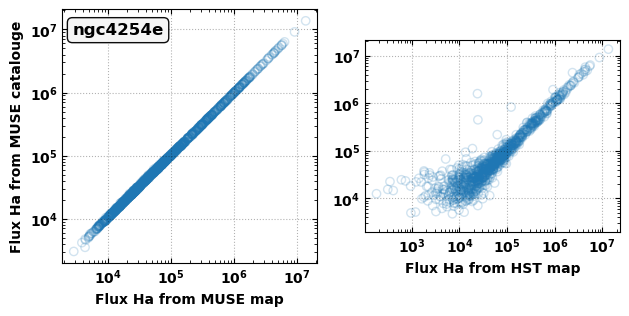

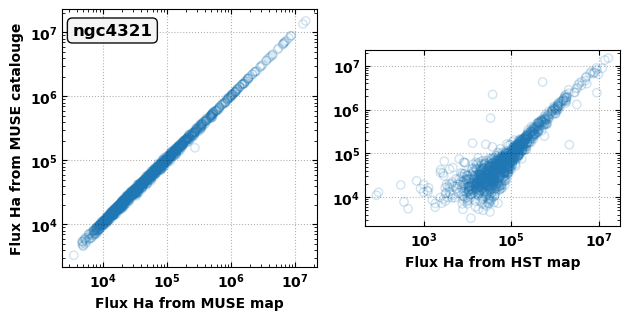

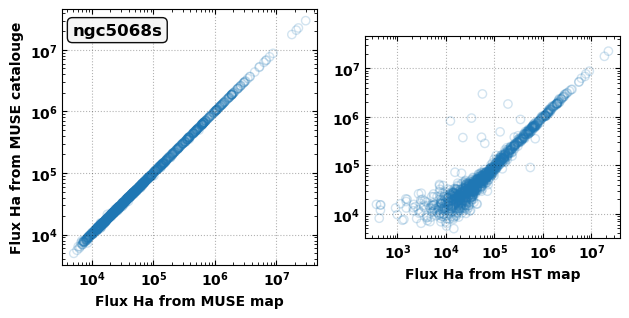

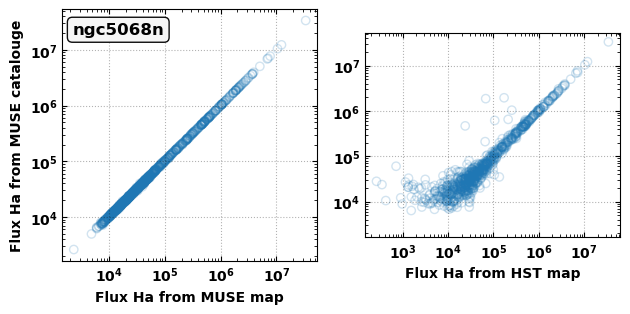

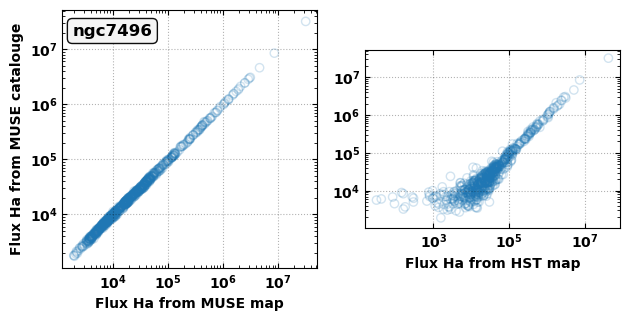

In [7]:
for galaxy, galaxy_muse in zip(galaxies, galaxies_muse): 

    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, sharey=ax1)

    ax1.set_aspect('equal')
    ax2.set_aspect('equal')

    ax1.scatter(muscat_table_joined_all[galaxy]['flux_muse'], muscat_table_joined_all[galaxy]['HA6562_FLUX'], fc='none', ec='C0', alpha=0.2)
    ax2.scatter(muscat_table_joined_all[galaxy]['flux_hst'], muscat_table_joined_all[galaxy]['HA6562_FLUX'], fc='none', ec='C0', alpha=0.2)

    ax1.set_xlabel('Flux Ha from MUSE map')
    ax1.set_ylabel('Flux Ha from MUSE catalouge')
    ax2.set_xlabel('Flux Ha from HST map')

    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax2.set_xscale('log')
    ax2.set_yscale('log')

    ax1.text(0.04, 0.9, '%s' %galaxy, transform=ax1.transAxes, bbox=bbox, fontsize=12)

    ax1.grid(True, alpha=0.3, ls=':', color='black')
    ax2.grid(True, alpha=0.3, ls=':', color='black')
    fig.tight_layout()

    fig.savefig('./figs/%s_fluxcomp.pdf' %galaxy, bbox_inches='tight', dpi=300)  

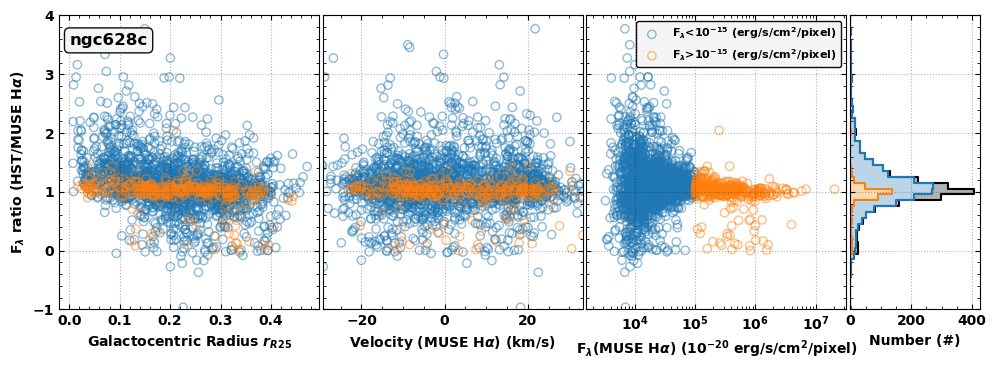

In [54]:
# galaxies = ['ngc628c']
# galaxies_muse = ['ngc0628']

for galaxy, galaxy_muse in zip(galaxies, galaxies_muse): 

    fig = plt.figure(figsize=(10, 3.8))

    from matplotlib import gridspec
    gs = gridspec.GridSpec(1, 4, width_ratios=[1,1,1,0.5]) 

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])
    ax4 = fig.add_subplot(gs[3])

    ratio = muscat_table_joined_all[galaxy]['flux_hst/muse']
    mask = ratio!=0

    mask_lum = muscat_table_joined_all[galaxy]['HA6562_FLUX'][mask] > 1e5

    ax1.scatter(muscat_table_joined_all[galaxy]['r_R25'][mask][~mask_lum], ratio[mask][~mask_lum], fc='none', ec='C0', alpha=0.5)
    ax2.scatter(muscat_table_joined_all[galaxy]['HA6562_VEL'][mask][~mask_lum], ratio[mask][~mask_lum], fc='none', ec='C0', alpha=0.5)
    ax3.scatter(muscat_table_joined_all[galaxy]['HA6562_FLUX'][mask][~mask_lum], ratio[mask][~mask_lum], fc='none', ec='C0', alpha=0.5, label='F$_\lambda$<$10^{-15}$ (erg/s/cm$^2$/pixel)')

    ax1.scatter(muscat_table_joined_all[galaxy]['r_R25'][mask][mask_lum], ratio[mask][mask_lum], fc='none', ec='C1', alpha=0.5)
    ax2.scatter(muscat_table_joined_all[galaxy]['HA6562_VEL'][mask][mask_lum], ratio[mask][mask_lum], fc='none', ec='C1', alpha=0.5)
    ax3.scatter(muscat_table_joined_all[galaxy]['HA6562_FLUX'][mask][mask_lum], ratio[mask][mask_lum], fc='none', ec='C1', alpha=0.5, label='F$_\lambda$>$10^{-15}$ (erg/s/cm$^2$/pixel)')

    bins = np.arange(-10,10,0.1)
    data_hist, bins_edges = np.histogram(ratio[mask], bins=bins)
    data_hist_lmask1, bins_edges = np.histogram(ratio[mask][~mask_lum], bins=bins)
    data_hist_lmask2, bins_edges = np.histogram(ratio[mask][mask_lum], bins=bins)
    bins_center = np.linspace(bins_edges.min(), bins_edges.max(), len(bins_edges)-1)
    
    ax4.plot(data_hist, bins_center, ds='steps-post', c='black', zorder=1)
    ax4.fill_betweenx(bins_center, data_hist, x2=np.nanmax([data_hist_lmask1,data_hist_lmask2], axis=0), step="pre", alpha=0.3, zorder=0, fc='black')

    ax4.plot(data_hist_lmask1, bins_center, ds='steps-post', c='C0', zorder=2)
    ax4.fill_betweenx(bins_center, data_hist_lmask1, x2=-5, step="pre", alpha=0.3, zorder=0, fc='C0')

    ax4.fill_betweenx(bins_center, data_hist_lmask2, x2=-5, step="pre", alpha=1, zorder=0, fc='white')
    ax4.plot(data_hist_lmask2, bins_center, ds='steps-post', c='C1', zorder=2)
    ax4.fill_betweenx(bins_center, data_hist_lmask2, x2=-5, step="pre", alpha=0.3, zorder=0, fc='C1')

    ax1.set_ylabel(r'F$_\lambda$ ratio (HST/MUSE H$\alpha$)')
    ax1.set_xlabel(r'Galactocentric Radius $r_{R25}$')
    ax2.set_xlabel(r'Velocity (MUSE H$\alpha$) (km/s)')
    ax3.set_xlabel(r'F$_\lambda$(MUSE H$\alpha$) (10$^{-20}$ erg/s/cm$^2$/pixel)')
    ax4.set_xlabel('Number (#)')

    for ax in [ax1,ax2,ax3,ax4]:

        ax.set_ylim(-1, 4)
        ax.grid(True, alpha=0.3, ls=':', color='black')

    ax1.set_xlim([-.02, muscat_table_joined_all[galaxy]['r_R25'][mask].max()*1.05])
    ax2.set_xlim(np.nanpercentile(muscat_table_joined_all[galaxy]['HA6562_VEL'][mask], [0.5,99.5]))
    ax4.set_xlim([-1, data_hist.max()*1.05])

    ax3.set_xscale('log')

    ax2.set_yticklabels([])
    ax3.set_yticklabels([])
    ax4.set_yticklabels([])

    ax3.legend(facecolor='whitesmoke', framealpha=0.95, edgecolor='k', loc='upper right', fontsize=8)

    for ax in [ax1,ax2,ax4]:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax3.yaxis.set_minor_locator(AutoMinorLocator())

    ax1.text(0.04, 0.9, '%s' %galaxy, transform=ax1.transAxes, bbox=bbox, fontsize=12)

    plt.tight_layout(h_pad=0, w_pad=-1)
    fig.savefig('./figs/%s_ratiocomp.pdf' %galaxy, bbox_inches='tight', dpi=300)  

ngc628e: 0.20 0.08
ngc628c: 0.21 0.08
ngc1087: 0.21 0.11
ngc1300: 0.22 0.11
ngc1365n: 0.44 0.13
ngc1385: 0.15 0.08
ngc1433: 0.36 0.08
ngc1566: 0.23 0.11
ngc1672: 0.27 0.12
ngc3351: 0.53 0.15
ngc4254e: 0.21 0.11
ngc4321: 0.36 0.16
ngc5068s: 0.17 0.08
ngc5068n: 0.17 0.08
ngc7496: 0.24 0.10


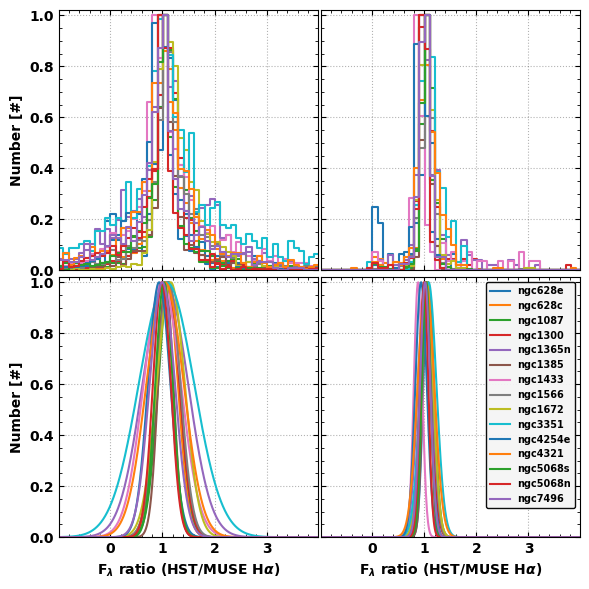

In [9]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

g_init = models.Gaussian1D(amplitude=1., mean=1, stddev=0.2)
fit_g = fitting.LevMarLSQFitter()

for galaxy, galaxy_muse in zip(galaxies, galaxies_muse): 

    ratio = muscat_table_joined_all[galaxy]['flux_hst/muse']
    mask = ratio!=0
    mask_lum = muscat_table_joined_all[galaxy]['HA6562_FLUX'][mask] > 1e5

    bins = np.arange(-10,10,0.1)
    data_hist, bins_edges = np.histogram(ratio[mask], bins=bins)
    data_hist_lmask1, bins_edges = np.histogram(ratio[mask][~mask_lum], bins=bins)
    data_hist_lmask2, bins_edges = np.histogram(ratio[mask][mask_lum], bins=bins)
    bins_center = np.linspace(bins_edges.min(), bins_edges.max(), len(bins_edges)-1)

    data_hist = data_hist/data_hist.max()
    data_hist_lmask2 = data_hist_lmask2/data_hist_lmask2.max()
    
    g = fit_g(g_init, bins_center, data_hist)
    g_lmask2 = fit_g(g_init, bins_center, data_hist_lmask2)
    print('%s: %0.2f %0.2f' %(galaxy,g.stddev.value, g_lmask2.stddev.value))

    ax1.plot(bins_center, data_hist, ds='steps-mid', label='%s' %galaxy)
    # ax1.fill_between(bins_center, data_hist, y2=0, step="mid", alpha=0.2, zorder=0)

    ax2.plot(bins_center, data_hist_lmask2, ds='steps-mid', label='%s' %galaxy)
    # ax2.fill_between(bins_center, data_hist_lmask2, y2=0, step="mid", alpha=0.2, zorder=0)

    bins = np.arange(-10,10,0.01)
    ax3.plot(bins, g(bins)/g(bins).max(), label='%s' %galaxy)
    ax4.plot(bins, g_lmask2(bins)/g_lmask2(bins).max(), label='%s' %galaxy)

for ax in [ax1, ax2, ax3, ax4]:

    ax.set_xlim(-0.99, 3.99)
    ax.grid(True, alpha=0.3, ls=':', color='black')
    ax.set_ylim([0, 1.02])
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

ax4.legend(facecolor='whitesmoke', framealpha=0.95, edgecolor='k', fontsize=7)

for ax in [ax2, ax4]:
    ax.set_yticklabels([])

for ax in [ax1, ax2]:
    ax.set_xticklabels([])

ax3.set_xlabel(r'F$_\lambda$ ratio (HST/MUSE H$\alpha$)')
ax4.set_xlabel(r'F$_\lambda$ ratio (HST/MUSE H$\alpha$)')
ax1.set_ylabel('Number [#]')
ax3.set_ylabel('Number [#]')

fig.tight_layout(h_pad=-1, w_pad=0.2)
fig.savefig('./figs/all_ratiohist.pdf', bbox_inches='tight', dpi=300)  

0.24 0.11


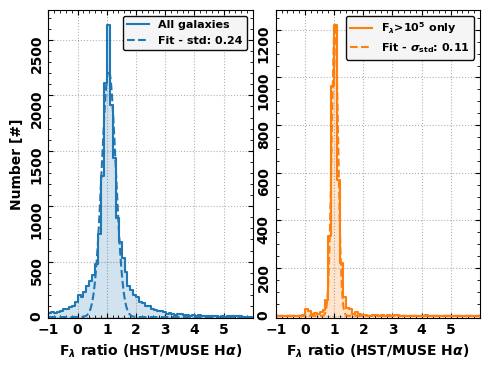

In [61]:
fig = plt.figure(figsize=(5, 3.8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

g_init = models.Gaussian1D(amplitude=1., mean=1, stddev=0.2)
fit_g = fitting.LevMarLSQFitter()

ratio = []
lum = []

for galaxy, galaxy_muse in zip(galaxies, galaxies_muse): 

    ratio += [np.squeeze(muscat_table_joined_all[galaxy]['flux_hst/muse'].quantity.value)]
    lum += [np.squeeze(muscat_table_joined_all[galaxy]['HA6562_FLUX'].quantity.value)]

ratio = np.hstack(ratio)
lum = np.hstack(lum)

mask = ratio!=0
mask_lum = lum[mask] > 1e5

bins = np.arange(-10,10,0.1)
data_hist, bins_edges = np.histogram(ratio[mask], bins=bins)
data_hist_lmask1, bins_edges = np.histogram(ratio[mask][~mask_lum], bins=bins)
data_hist_lmask2, bins_edges = np.histogram(ratio[mask][mask_lum], bins=bins)
bins_center = np.linspace(bins_edges.min(), bins_edges.max(), len(bins_edges)-1)

# data_hist = data_hist/data_hist.max()
# data_hist_lmask2 = data_hist_lmask2/data_hist_lmask2.max()

g = fit_g(g_init, bins_center, data_hist)
g_lmask2 = fit_g(g_init, bins_center, data_hist_lmask2)
print('%0.2f %0.2f' %(g.stddev.value, g_lmask2.stddev.value))

ax1.plot(bins_center, data_hist, ds='steps-mid', label='All galaxies')
ax2.plot(bins_center, data_hist_lmask2, ds='steps-mid', label=r'F$_\lambda$>$10^5$ only', c='C1')

ax1.fill_between(bins_center, data_hist, y2=-100, step="mid", alpha=0.2, zorder=0)
ax2.fill_between(bins_center, data_hist_lmask2, y2=-100, step="mid", alpha=0.2, zorder=0, fc='C1')

bins = np.arange(-10,10,0.01)
ax1.plot(bins, g(bins), label='Fit - std: %0.2f' %g.stddev.value, c='C0', ls='--')
ax2.plot(bins, g_lmask2(bins), label='Fit - $\sigma_\mathrm{std}$: %0.2f' %g_lmask2.stddev.value, c='C1', ls='--')

for ax in [ax1, ax2]:

    ax.set_xlim(-0.99, 6)
    ax.set_xticks(np.arange(-1,6))
    ax.grid(True, alpha=0.3, ls=':', color='black')
    
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.legend(facecolor='whitesmoke', framealpha=0.95, edgecolor='k', fontsize=8, loc='upper right')

ax1.set_ylim([-10, data_hist.max()*1.05])
ax2.set_ylim([-10, data_hist_lmask2.max()*1.05])

for label in ax1.get_yticklabels():
  label.set_rotation(90)
  label.set_ha('right')

for label in ax2.get_yticklabels():
  label.set_rotation(90)
  label.set_ha('right')
  # label.set_va('bottom')


ax1.set_xlabel(r'F$_\lambda$ ratio (HST/MUSE H$\alpha$)')
ax2.set_xlabel(r'F$_\lambda$ ratio (HST/MUSE H$\alpha$)')
ax1.set_ylabel('Number [#]')

fig.tight_layout(h_pad=-1, w_pad=0.3)
fig.savefig('./figs/allcomb_ratiohist.pdf', bbox_inches='tight', dpi=300)  